In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt

In [2]:
with open('results/2019-11-16_12-35-14_smooth_monotonic/smooth_monotonic_modeling_result.pkl', 'rb') as handle:
    x = pickle.load(handle)

In [70]:
x_subsample = x.final.b_nn_corrected[::50][300:]
x_subsample = x_subsample.reshape(-1,1)
time_subsample = x.base_signals.t_b_nn[::50][300:]
time_subsample = time_subsample.reshape(-1,1)
mean = np.mean(x_subsample)
X, Y = time_subsample, x_subsample - mean
np.size(time_subsample)

482

In [71]:
mean

1365.8116579232885

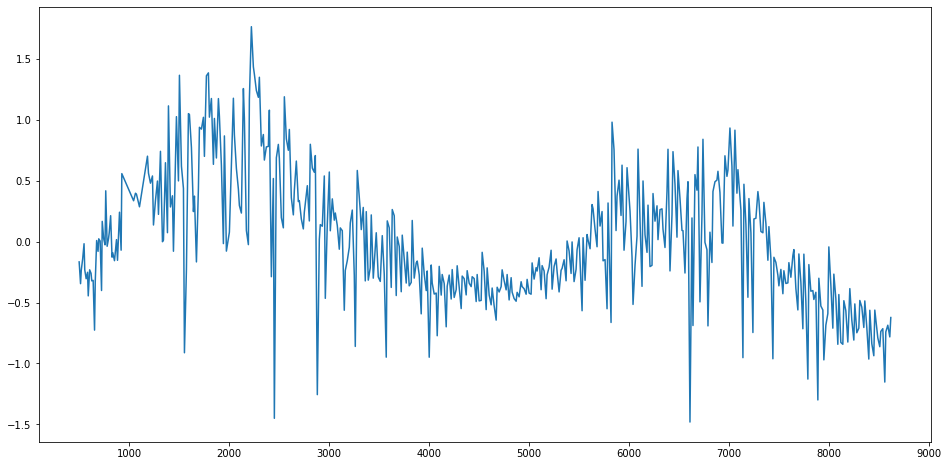

In [72]:
plt.figure(5, figsize=(16, 8))
#plt.ylim(1362.5, 1370)
plt.plot(X, Y)

In [73]:
import gpflow
import matplotlib
from gpflow.utilities import print_summary

# The lines below are specific to the notebook format
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

In [74]:
k = gpflow.kernels.Sum([gpflow.kernels.Matern32(),gpflow.kernels.White()])

In [75]:
print_summary(k)

name                        class      transform    trainable    shape    dtype      value
--------------------------  ---------  -----------  -----------  -------  -------  -------
Sum.kernels[0].variance     Parameter  Softplus     True         ()       float64        1
Sum.kernels[0].lengthscale  Parameter  Softplus     True         ()       float64        1
Sum.kernels[1].variance     Parameter  Softplus     True         ()       float64        1


In [76]:
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)

In [77]:
print_summary(m)

name                               class      transform    trainable    shape    dtype      value
---------------------------------  ---------  -----------  -----------  -------  -------  -------
GPR.kernel.kernels[0].variance     Parameter  Softplus     True         ()       float64        1
GPR.kernel.kernels[0].lengthscale  Parameter  Softplus     True         ()       float64        1
GPR.kernel.kernels[1].variance     Parameter  Softplus     True         ()       float64        1
GPR.likelihood.variance            Parameter  Softplus     True         ()       float64        1


In [104]:
m.likelihood.variance.assign(1e-1)
m.kernel.kernels[0].variance.assign(1)
m.kernel.kernels[0].lengthscale.assign(427)
m.kernel.kernels[1].variance.assign(0.0544)

In [101]:
opt = gpflow.optimizers.Scipy()

In [102]:
def objective_closure():
    return - m.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))
print_summary(m)

name                               class      transform    trainable    shape    dtype           value
---------------------------------  ---------  -----------  -----------  -------  -------  ------------
GPR.kernel.kernels[0].variance     Parameter  Softplus     True         ()       float64     0.251739
GPR.kernel.kernels[0].lengthscale  Parameter  Softplus     True         ()       float64  1495.78
GPR.kernel.kernels[1].variance     Parameter  Softplus     True         ()       float64     0.0633807
GPR.likelihood.variance            Parameter  Softplus     True         ()       float64     0.0584289


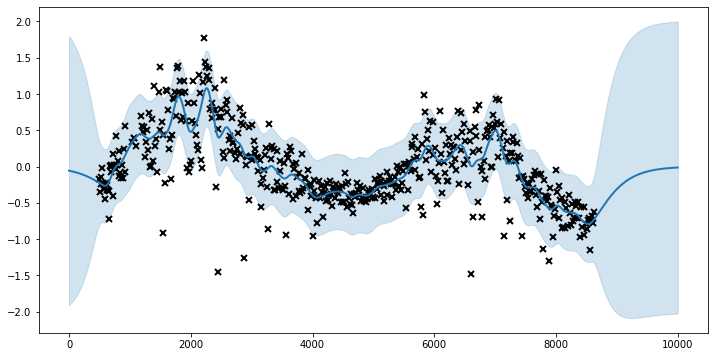

In [105]:

## generate test points for prediction
xx = np.linspace(0, 10000, 1000).reshape(1000, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
#samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
plt.figure(figsize=(12, 6))
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'C0', lw=2)
plt.fill_between(xx[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

#plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)

In [93]:
print_summary(m)

name                               class      transform    trainable    shape    dtype       value
---------------------------------  ---------  -----------  -----------  -------  -------  --------
GPR.kernel.kernels[0].variance     Parameter  Softplus     True         ()       float64    1
GPR.kernel.kernels[0].lengthscale  Parameter  Softplus     True         ()       float64  427
GPR.kernel.kernels[1].variance     Parameter  Softplus     True         ()       float64    0.0544
GPR.likelihood.variance            Parameter  Softplus     True         ()       float64   10
